# Solving TSP using Genetic Algorithm

The travelling salesman problem is perhaps one of the most commonly known path optimisation problems which shows up in one form or another in our daily life. Imagine this: it is the weekend and you have a list of errands scattered all over the city that you want to complete before the day is over. You want to get everything done in the most efficient way possible, whether that involves travelling the least total distance, using the least fuel, or spending the least amount on tolls etc. The question is given the list of destinations and a certain aim (and maybe a few restraints), what is the optimum way of scheduling our errands for the day?

There are many methods available to solve this: Brute Force, Dynamic Programming, and Greedy Methods are just a few. In this notebook, we will focus on implementing the Genetic Algorithm method.

We will first create our own implementation. Then, we will see how we can use the [vcopt library's](https://pypi.org/project/vcopt/) accelerated GA functions to implement a much faster version of the Genetic Algorithm method in just a few simple steps.

Docs: https://vigne-cla.com/vcopt-specification/#toc9

Reference: https://vigne-cla.com/9-1/


<img src="visualisations/training_gif.gif" align="left">

# Basic single-salesman problem

We begin by considering the case where there is only one salesman. We let the cost of travelling between cities be simply the distance between each city. We also set the constraint that the start and end points must be the same, and we can only pass through each city once.

## Import Libraries

In [82]:
# import libs

import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import random
import copy
import time
import itertools

from vcopt import vcopt

## Initialise Parameters

We first initialise the following parameters:

1) NO_TOWNS: Number of towns to visit

2) STARTING_TOWN: Town number of the starting town (:NO_TOWNS)

In [126]:
# init parameters

NO_TOWNS = 10 # number of towns (town numbering is from [0, NO_TOWNS-1])
STARTING_TOWN = 0 # set starting town
nr.seed(69) # set fixed seed for rng

NO_POOL = 20


# Create TSP Problem

First, we will create a function ***create_towns*** to generate random coordinates for each town. Since our starting point and end points are going to be fixed, we will not need to consider the STARTING_TOWN in our permutations. Hence, we will remove it from our path.

However, we will need to consider the cost between the 2nd town and the STARTING_TOWN. We will also need to consider the cost between the 2nd last town, and the final town (which in this case is the STARTING_TOWN again). We will take these into account later in our cost_function.


**NOTE: vcopt requires its paths/chromosones to be a list or np.array.**

In [127]:
# function for creating town coordinates
def create_towns(NO_TOWNS):
    """generate random x and y coordinates for each town"""

    towns_x = nr.rand(NO_TOWNS) # x coordinates for NO_TOWNS number of towns
    towns_y = nr.rand(NO_TOWNS) # y coordinates for NO_TOWNS number of towns
    
    return towns_x, towns_y


towns_x, towns_y = create_towns(NO_TOWNS) # generate coordinates for each town

start_town_x = towns_x[STARTING_TOWN]
start_town_y = towns_y[STARTING_TOWN]

path = np.arange(NO_TOWNS) # generate a random initial path that passes through all towns 
path = np.delete(path, np.where(path==STARTING_TOWN)) # remove the starting town from the path


# Define Cost Function for optimisation

vcopt requires us to provide its optimiser with a cost function for optimisation. The cost function must take a path (dtype: list, np.array) and return a single value.

Here, we define our cost by splitting it into three parts:

1) Distance between each town in the path (excluding start and end towns).

    - Find the x, y displacements between each pair of towns (i, i+1), where i represents the i-th town we travel to on our current path. 
    - Calculate the straight-line distance by using Pythagoras theorem. 
    - Sum all the distances between each pair.
    
2) Distance between start town and 2nd town

3) Distance between 2nd last town and end town.

This gives the total cost of a path which includes starts from the STARTING_TOWN, goes through the other cities, and returns to the STARTING_TOWN.

In [128]:
# create scoring function for current path

def score_func(path):

    # 1) add costs between each non-starting town according to path
    cost = sum(((towns_y[path][1:] - towns_y[path][:-1])**2 + (towns_x[path][1:] - towns_x[path][:-1])**2)**0.5)
    
    # 2) add cost between first non-starting town and start town
    cost += ((towns_x[path][0] - start_town_x)**2 + (towns_y[path][0] - start_town_y)**2)**0.5 
    
    # 3) add cost between last non-starting town and start town
    cost += ((towns_x[path][-1] - start_town_x)**2 + (towns_y[path][-1] - start_town_y)**2)**0.5
    
    return cost

# Create plotting function to visualise optimisation process


vcopt's tspGA() function has multiple options for visualising the optimisation process ('bar', 'print', 'plot'). However, it also accepts a custom plotting function that allows us to use information on the current training generation. The plotting function must take 2 parameters:

1) ***pool*** (dtype: np.array): a 2D array where each row is a path/chromosone, and each column is a gene.

2) ***info*** (dtype: dict): a dict containing the following information

    {
        'gen': current generation of optimisation
        'best_index': index (row number) of best path in current gen's population
        'best_score': score/cost of best path in current gen's population
        'mean_score': mean score/cost of all the paths in the current gen's population
        'mean_gap:' mean difference between the cost of each path in the current gen's population and the goal cost
        'time': wall time elapsed since start of optimisation
     }

We will use information regarding the current generation's best path to plot it in red. We will also plot 10 of the population's paths in translucent (alpha=0.1) black in order to see what are the other paths that are in the current population.

In [129]:
# def plotting function for visualising paths at every step of optimisation


def tsp_show_pool(pool, **info):
    """function for visualising path at each generation"""
    # access the info dictionary provided by tspGA() function to get metrics

    print(info)
    
    gen = info['gen']
    best_index = info['best_index']
    best_score = info['best_score']
    mean_score = info['mean_score']
    mean_gap = info['mean_gap']
    time = info['time']
    
    
    plt.figure(figsize=(6, 6))
    
    # visualise some of the paths in each generation's population
    for para in pool[:10]:
        plt.plot(towns_x[para], towns_y[para], 'ok-', alpha=0.1)
    
    best_path_of_pool = np.concatenate(([STARTING_TOWN], pool[best_index], [STARTING_TOWN]))
    plt.plot(towns_x[best_path_of_pool], towns_y[best_path_of_pool], 'or-', linewidth=1.5)
    plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X

    plt.tick_params(     
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
    for i, xy in enumerate(zip(towns_x, towns_y), 0):
        plt.text(xy[0]+0.01, xy[1]+0.01, s=i)
        
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.title("(vcopt's GA Implementation)\ngen={}, best={:.3f} mean={:.3f} time={:.3f}".format(gen, best_score, mean_score, time))

    # saving the images
    plt.savefig(f'training_images/{gen}', facecolor='white', transparent=False)
    plt.show()
    

# Run Genetic Algorithm Optimisation

We can now use vcopt's tspGA() function to find the path that minimises the cost function (or at least gets as close to a global minimum).

vcopt().tspGA() takes the following parameters:

1) ***para_range*** (dtype:list, np.array): 

2) ***score_func*** (dtype: function):

3) ***aim*** (dtype: int, float, str):

4) ***show_pool_func*** (dtype: function):

5) ***seed*** (dtype: int):

6) ***pool_num*** (dtype: int > 1):

7) ***max_gen*** (dtype: int):

8) ***core_num*** (dtype: int):

Here, we simply input our own path, scoring function ***score_func***, and plotting function ***tsp_show_pool***. We also let our target cost be 0, since ideally we want it to be as small as possible.

We set our pool_num to be 20 (arbitrarily), and seed at 69 (its a good number).

[1 2 3 4 5 6 7 8 9]
________________________________________ info ________________________________________
para_range     : n=9
score_func     : <class 'function'>
aim            : ==0.0
show_pool_func : '<function tsp_show_pool at 0x0000018B12DD2200>'
seed           : 69
pool_num       : 20
max_gen        : 10000
core_num       : 1 (*vcopt, vc-grendel)
_______________________________________ start ________________________________________
Scoring first gen 20/20        
Mini 2-opting first gen 20/20        
{'gen': 0, 'best_index': 19, 'best_score': 3.94886570254831, 'mean_score': 4.635269688768904, 'mean_gap': 4.635269688768904, 'time': 0.011387109756469727}


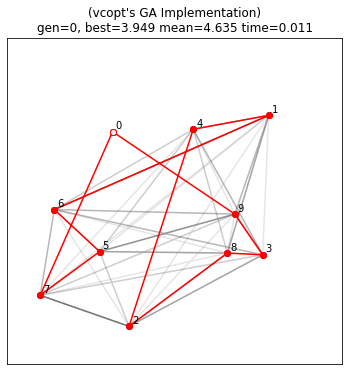

{'gen': 20, 'best_index': 9, 'best_score': 3.2259787857480045, 'mean_score': 3.8746408282237943, 'mean_gap': 3.8746408282237943, 'time': 0.5322515964508057}


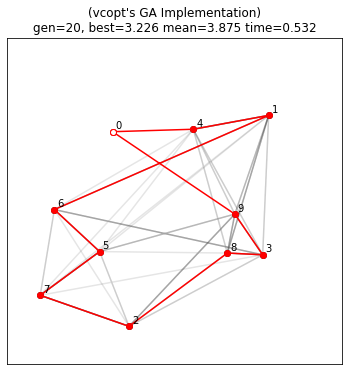

{'gen': 40, 'best_index': 9, 'best_score': 2.641134862573994, 'mean_score': 3.5748347977522235, 'mean_gap': 3.5748347977522235, 'time': 1.0517070293426514}


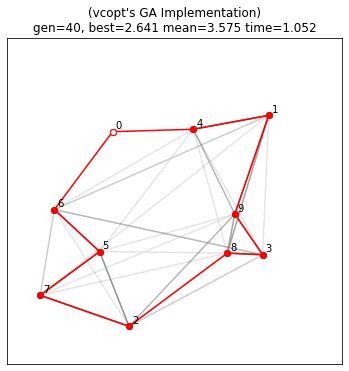

{'gen': 60, 'best_index': 9, 'best_score': 2.641134862573994, 'mean_score': 3.414149460759009, 'mean_gap': 3.414149460759009, 'time': 1.4258763790130615}


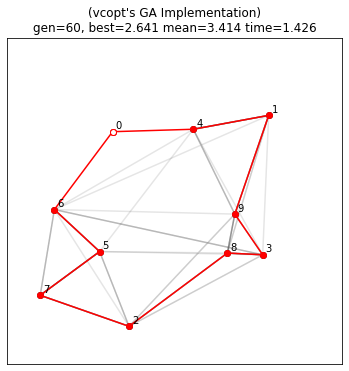

{'gen': 80, 'best_index': 9, 'best_score': 2.641134862573994, 'mean_score': 3.1812310313861594, 'mean_gap': 3.1812310313861594, 'time': 1.741657018661499}


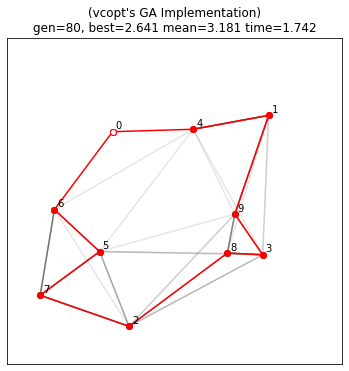

{'gen': 100, 'best_index': 8, 'best_score': 2.641134862573994, 'mean_score': 3.102309896271072, 'mean_gap': 3.102309896271072, 'time': 2.183609962463379}


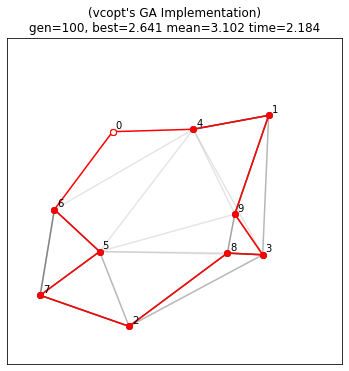

{'gen': 120, 'best_index': 0, 'best_score': 2.641134862573994, 'mean_score': 2.934249055711497, 'mean_gap': 2.934249055711497, 'time': 2.6619021892547607}


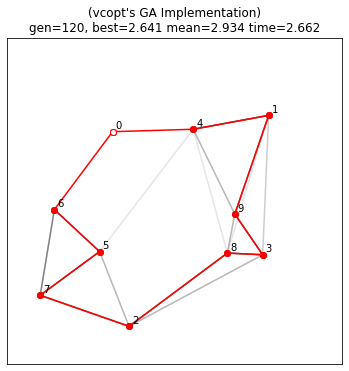

{'gen': 140, 'best_index': 0, 'best_score': 2.641134862573994, 'mean_score': 2.7732731884151716, 'mean_gap': 2.7732731884151716, 'time': 3.1479272842407227}


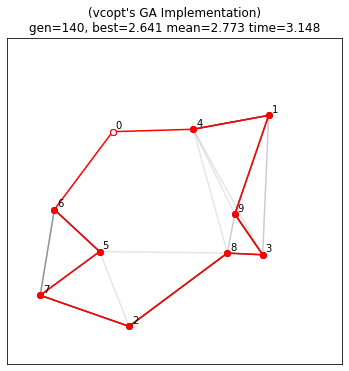

{'gen': 160, 'best_index': 0, 'best_score': 2.641134862573994, 'mean_score': 2.7213053059129995, 'mean_gap': 2.7213053059129995, 'time': 3.807177782058716}


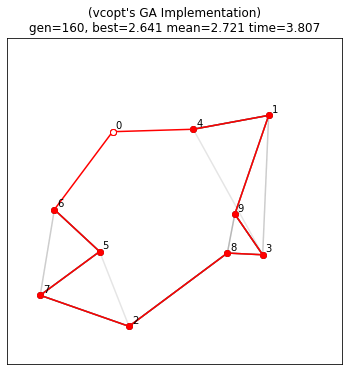

{'gen': 180, 'best_index': 0, 'best_score': 2.641134862573994, 'mean_score': 2.6716500315725957, 'mean_gap': 2.6716500315725957, 'time': 4.278990983963013}


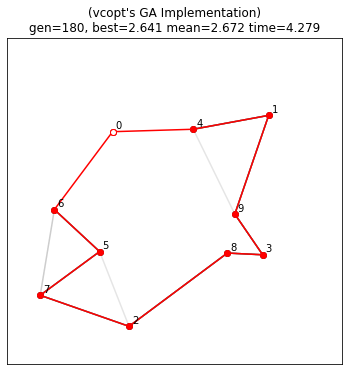

{'gen': 200, 'best_index': 0, 'best_score': 2.641134862573994, 'mean_score': 2.643508641623682, 'mean_gap': 2.643508641623682, 'time': 4.7207932472229}


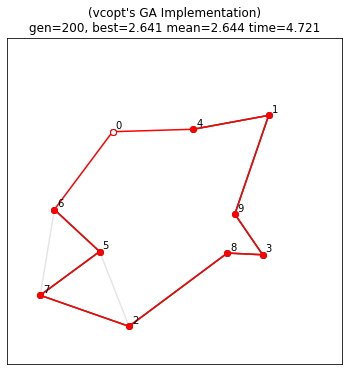

{'gen': 220, 'best_index': 0, 'best_score': 2.641134862573994, 'mean_score': 2.6411348625739937, 'mean_gap': 2.6411348625739937, 'time': 5.676962614059448}


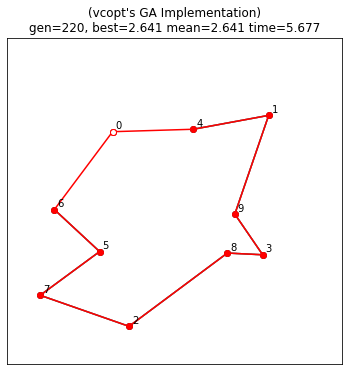

{'gen': 240, 'best_index': 0, 'best_score': 2.641134862573994, 'mean_score': 2.6411348625739937, 'mean_gap': 2.6411348625739937, 'time': 6.379129886627197}


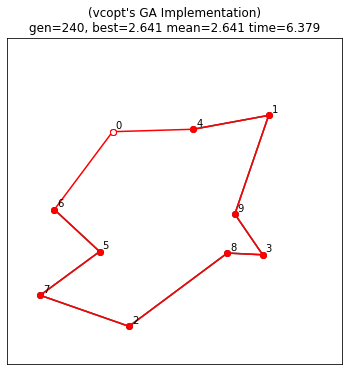

_______________________________________ result _______________________________________
para = np.array([4, 1, 9, 3, 8, 2, 7, 5, 6])
score = 2.641134862573994
________________________________________ end _________________________________________
[4 1 9 3 8 2 7 5 6]
2.641134862573994
CPU times: total: 6.14 s
Wall time: 6.8 s


In [130]:
%%time

print(path) 

walltime = time.time()
cputime = time.process_time()

best_path, score = vcopt().tspGA(path,                            # input our initial guess at a path
                            score_func,                            # input our custom cost function
                            0.0,                            # we want to minimise our score which measures total distance
                            show_pool_func=tsp_show_pool,                            # input our custom plotting function
                            max_gen=MAX_GEN,
                            pool_num=NO_POOL,                            # number of paths in each generation's population
                            seed=69,                                # seed for reproducible results
                            ) 
vcopt_walltime = time.time()-walltime
vcopt_cputime = time.process_time()-cputime

print(best_path)
print(score)

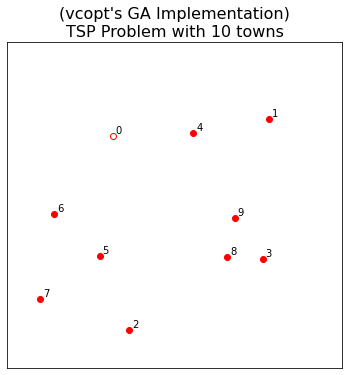

In [131]:
plt.figure(figsize=(6, 6))

for i in range(NO_TOWNS):
    if i == STARTING_TOWN:
        plt.scatter(towns_x[i], towns_y[i], c='white', edgecolors='red')
        
    else:
        plt.scatter(towns_x[i], towns_y[i], c='red')
        

    plt.text(towns_x[i]+0.01, towns_y[i]+0.01, i)

plt.title(f"(vcopt's GA Implementation)\nTSP Problem with {NO_TOWNS} towns", fontsize=16)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.tick_params(     
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
plt.savefig('visualisations/Init.png', facecolor='white', transparent=False)

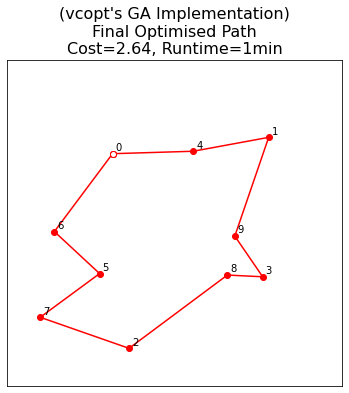

In [132]:
plt.figure(figsize=(6, 6))

best_path = np.concatenate(([STARTING_TOWN], best_path, [STARTING_TOWN]))

plt.plot(towns_x[best_path], towns_y[best_path], 'or-')
plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X

for i, xy in enumerate(zip(towns_x, towns_y), 0):
    plt.text(xy[0]+0.01, xy[1]+0.01, s=i)

plt.title(f"(vcopt's GA Implementation)\nFinal Optimised Path\nCost={score:.3}, Runtime=1min", fontsize=16)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.tick_params(     
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
plt.savefig('visualisations/Optimised Path.png', facecolor='white', transparent=False)

# Extra Stuff: Create GIF of Optimisation Process

In [133]:
# import libraries

import os
import imageio
from decimal import *

In [134]:
png_dir = 'training_images'
images = []
    
for i in range(15):
    images.append(imageio.v2.imread('visualisations/Init.png'))
    
for file_name in sorted([int(i.replace('.png','')) for i in os.listdir(png_dir)]):
    file_path = os.path.join(png_dir, str(file_name) + '.png')
    images.append(imageio.v2.imread(file_path))
    
for i in range(15):
    images.append(imageio.v2.imread('visualisations/Optimised Path.png'))
    
imageio.mimsave('training_gif.gif', images, duration=0.1)

# GA (Self Implementation)

In [135]:
def score_func(path):

    # 1) add costs between each non-starting town according to path
    cost = sum(((towns_y[path][1:] - towns_y[path][:-1])**2 + (towns_x[path][1:] - towns_x[path][:-1])**2)**0.5)
    
    # 2) add cost between first non-starting town and start town
    cost += ((towns_x[path][0] - start_town_x)**2 + (towns_y[path][0] - start_town_y)**2)**0.5 
    
    # 3) add cost between last non-starting town and start town
    cost += ((towns_x[path][-1] - start_town_x)**2 + (towns_y[path][-1] - start_town_y)**2)**0.5
    
    return cost


def create_population(path, NO_POOL):
    """
    Generate a population by finding NO_POOL permutations of an initial given path
    
    """
    
    population = []
    costs = []
    
    for i in range(NO_POOL):
        pool = np.array(random.sample(list(path), len(path)))
        population.append(pool)        
        costs.append(score_func(pool))
                     
    return population, costs


def choose_pool(population, costs):
    """
    Randomly choose a pool from a population.
    Pools with higher costs have lower probability of being chosen.
    """
    
        
    costs = np.array(costs)
    probs = np.exp(-costs)/sum(np.exp(-costs))
    cum_probs = np.cumsum(probs)
    
    choice = np.argwhere(nr.random()<=cum_probs)[0][0]

    return choice


def reproduce(population, costs):
    """
    First chooses 2 parent pool from current population via choose_pool.
    Then generates two child pool via CX2 crossover algorithm (Hussain et al., 2017).
    
    References:
    Hussain, A., Muhammad, Y. S., Nauman Sajid, M., Hussain, I., Mohamd Shoukry, A., &amp; Gani, S. (2017). 
    Genetic algorithm for traveling salesman problem with modified cycle crossover operator. 
    Computational Intelligence and Neuroscience, 2017, 1–7. https://doi.org/10.1155/2017/7430125 
    """
    
    
    p1 = population[choose_pool(population, costs)]
    p2 = population[choose_pool(population, costs)]
    
    c1 = []
    c2 = []
    
    # CX2 algorithm    
    current_index = 0
    
    c1.append(p2[0])
    
    while not (len(c1) == NO_TOWNS-1) or not (len(c2) == NO_TOWNS-1):


        if len(c2) < len(c1):
            current_index = np.argwhere(p1 == p2[np.argwhere(p1 == p2[current_index])[0][0]])[0][0]
            c2.append(p2[current_index])

        elif len(c2) == len(c1):
            current_index = np.argwhere(p1 == p2[current_index])[0][0]

            if p2[current_index] in c1: # case 1
                current_index = np.argwhere(p2 == [i for i in p2 if i not in c1][0])[0][0]

            c1.append(p2[current_index])

    return c1, c2


def mutate(pool, mutation_rate):
    """
    Randomly mutates a pool by swapping gene positions.
    """
    
    
    for i in range(len(pool)):
        if random.random() <= mutation_rate:
            j = int(random.random()*len(pool))
            pool[i], pool[j] = pool[j], pool[i]
    
    return pool
    

def evolution(population, costs, mutation_rate, gen, start_time):
    """
    Creates a new population of size NO_POOL by keeping only the reproduced/mutated pools with the best scores (in
    this case we keep those with the lowest score). 
    """
    c1, c2 = reproduce(population, costs)
    
    c1 = mutate(c1, mutation_rate)
    c2 = mutate(c2, mutation_rate)
    
    cost_c1 = score_func(c1)
    cost_c2 = score_func(c2)

    population.append(c1)
    population.append(c2)
    costs.append(cost_c1)
    costs.append(cost_c2)
    
    population = [x for _, x in sorted(zip(costs, population), key=lambda pair: pair[0])][:20]
    
    costs = sorted(costs)[:20]

    info = {}
    info['gen'] = gen
    info['best_index'] = 0
    info['best_score'] = costs[0]
    info['mean_score'] = np.mean(costs)
    info['time'] = time.time() - START_TIME    
    
    return population, costs, info


def tsp_show_pool(pool, **info):
    """function for visualising path at each generation"""
    # access the info dictionary provided by tspGA() function to get metrics

    
    gen = info['gen']
    best_index = info['best_index']
    best_score = info['best_score']
    mean_score = info['mean_score']
    time = info['time']
    
    
    plt.figure(figsize=(6, 6))
    
    # visualise some of the paths in each generation's population
    for para in pool[:10]:
        plt.plot(towns_x[para], towns_y[para], 'ok-', alpha=0.1)
    
    best_path_of_pool = np.concatenate(([STARTING_TOWN], pool[best_index], [STARTING_TOWN]))
    plt.plot(towns_x[best_path_of_pool], towns_y[best_path_of_pool], 'or-', linewidth=1.5)
    plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X

    plt.tick_params(     
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
    for i, xy in enumerate(zip(towns_x, towns_y), 0):
        plt.text(xy[0]+0.01, xy[1]+0.01, s=i)
        
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.title('(Basic GA)\ngen={}, best={:.3f} mean={:.3f} time={:.3f}'.format(gen, best_score, mean_score, time))

    # saving the images
    plt.savefig(f'training_images_self/{gen}', facecolor='white', transparent=False)
    plt.show()
    

In [136]:
population, costs = create_population(path, NO_POOL)

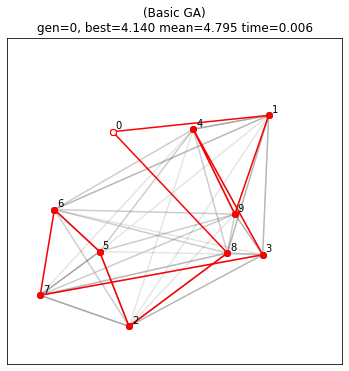

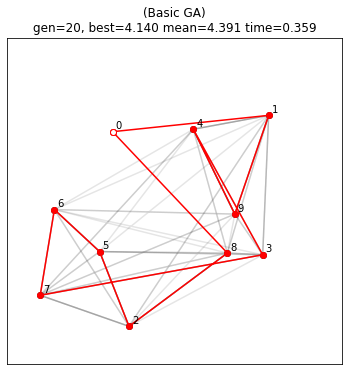

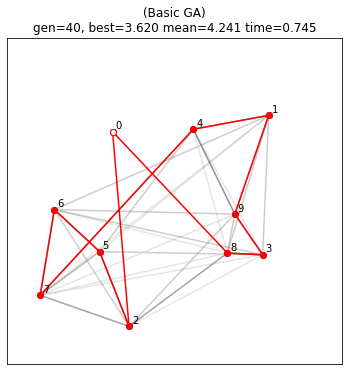

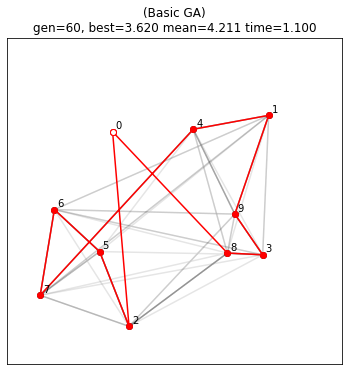

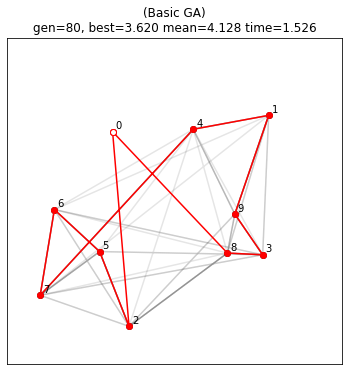

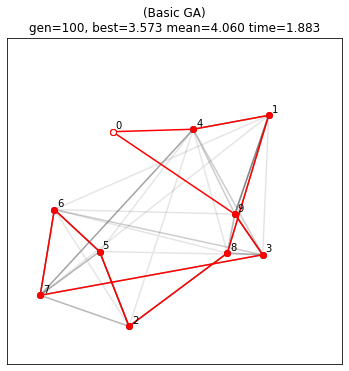

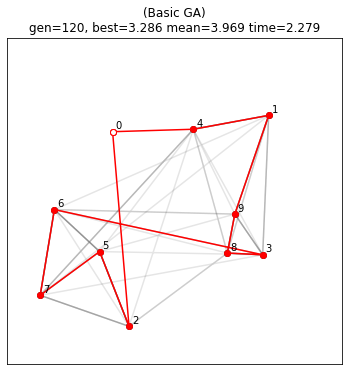

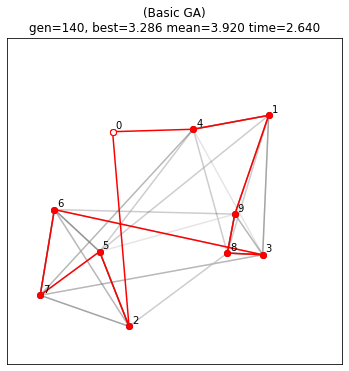

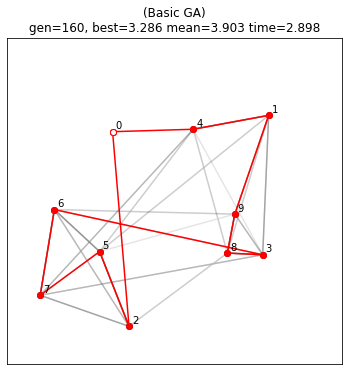

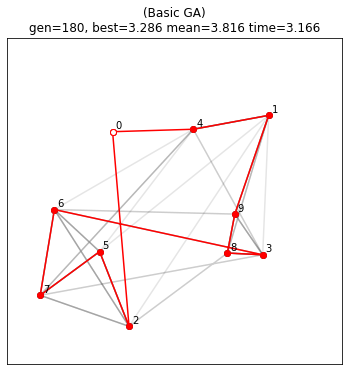

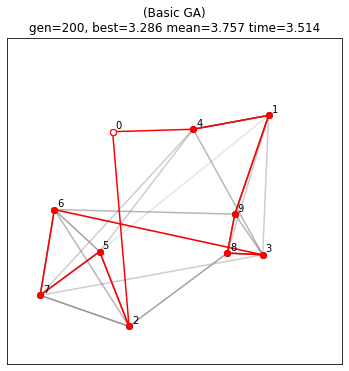

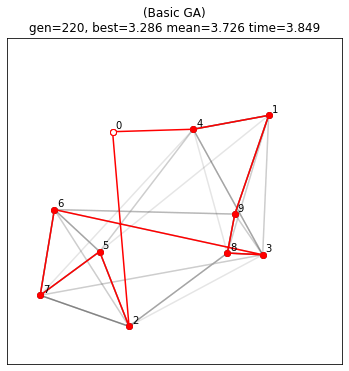

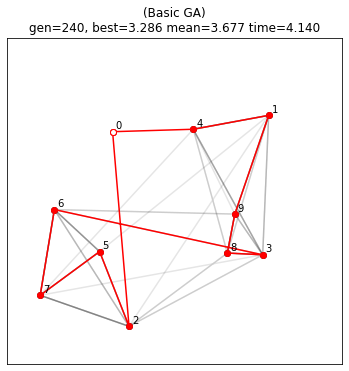

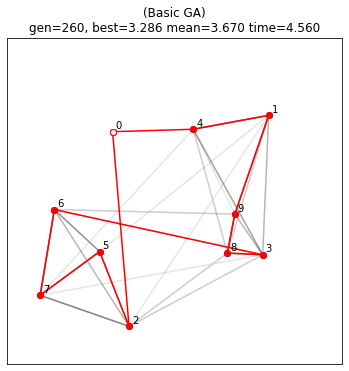

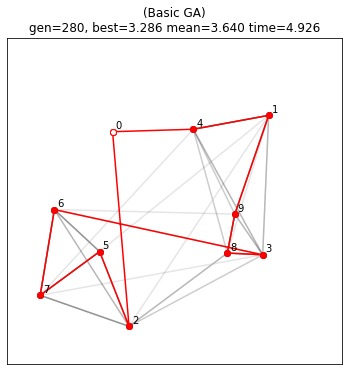

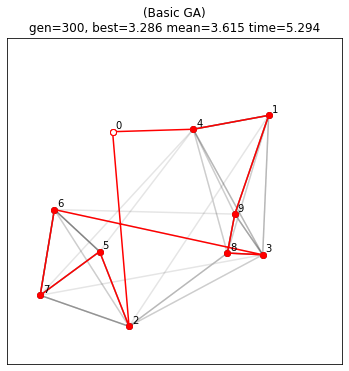

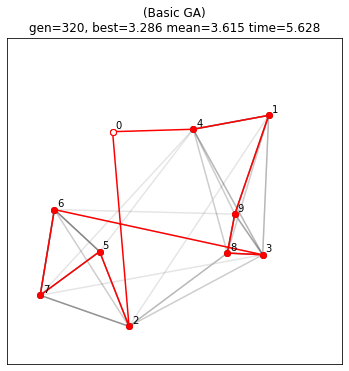

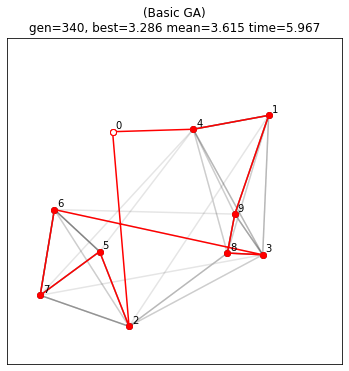

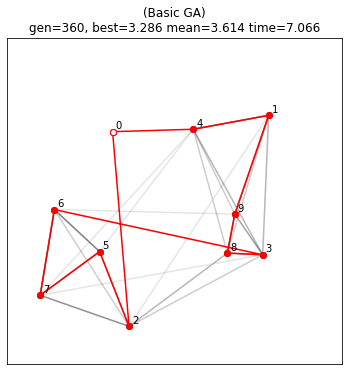

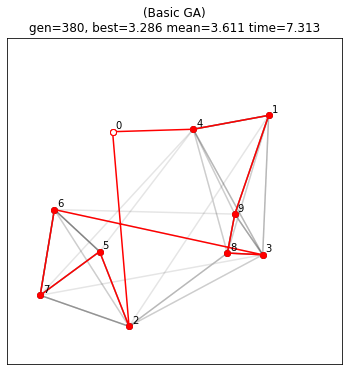

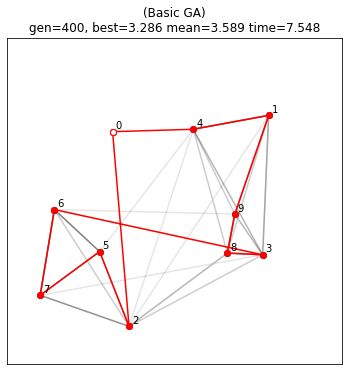

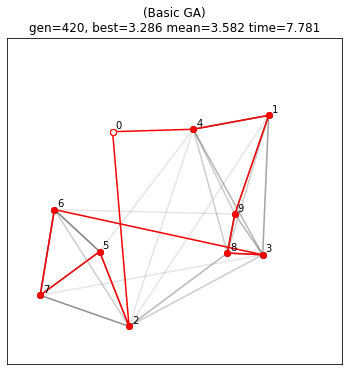

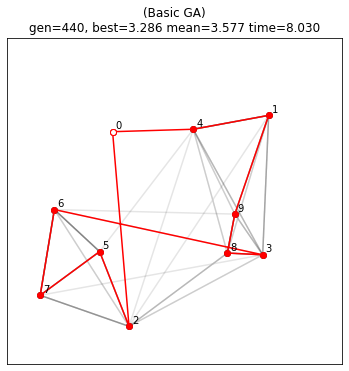

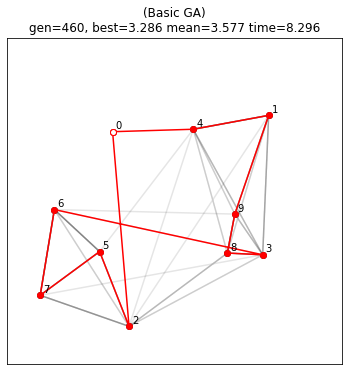

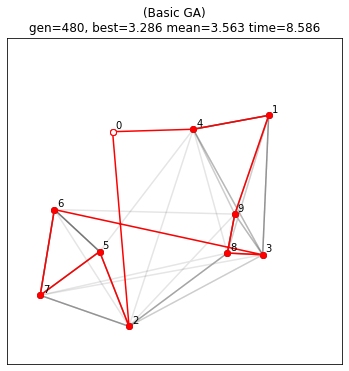

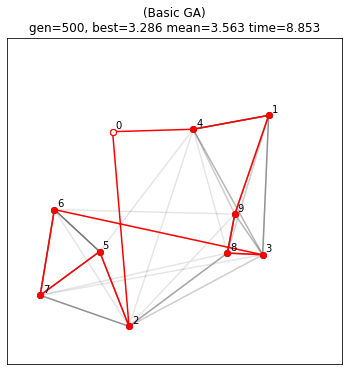

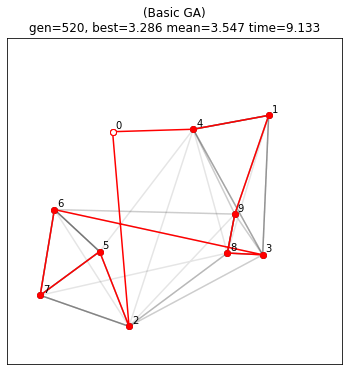

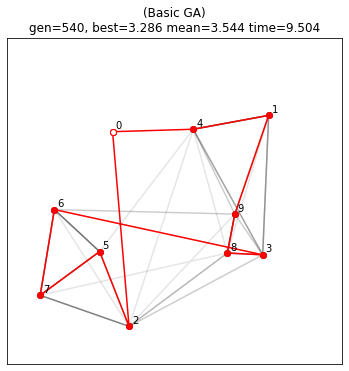

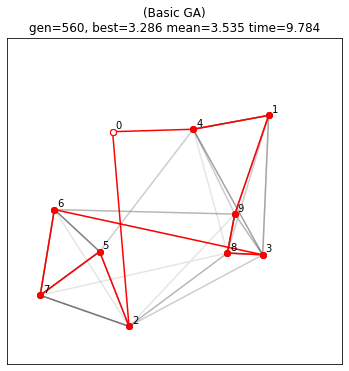

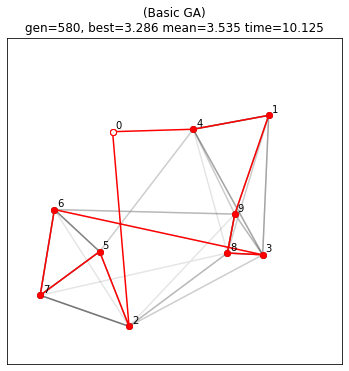

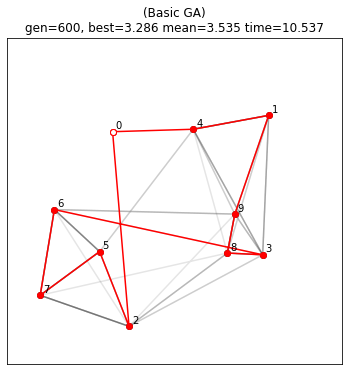

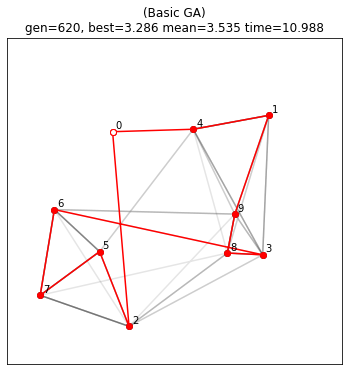

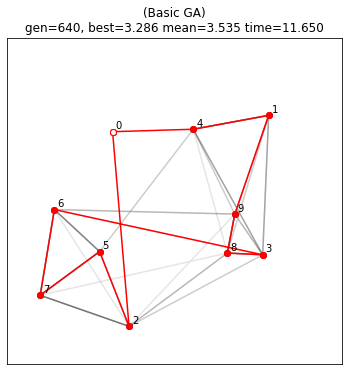

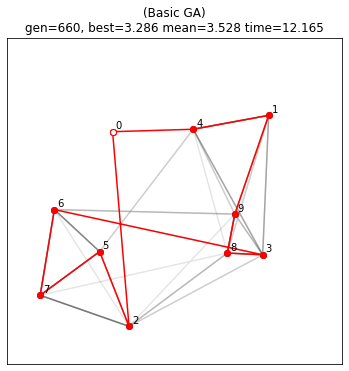

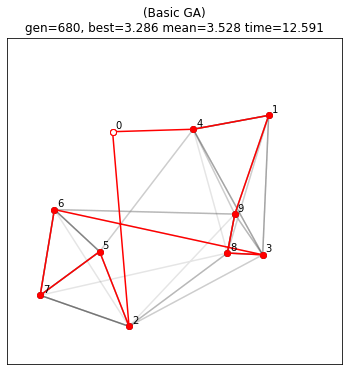

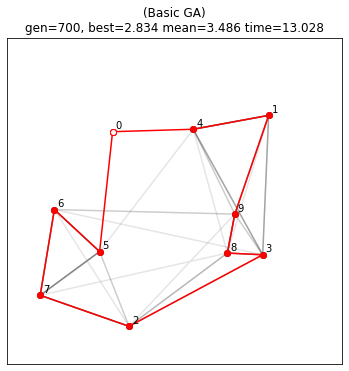

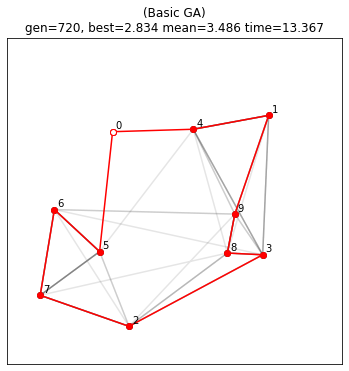

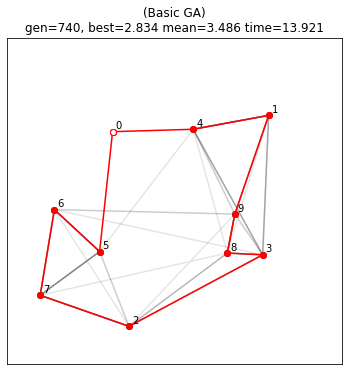

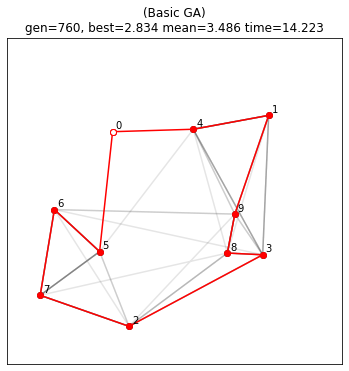

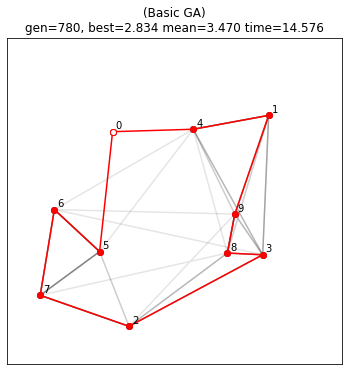

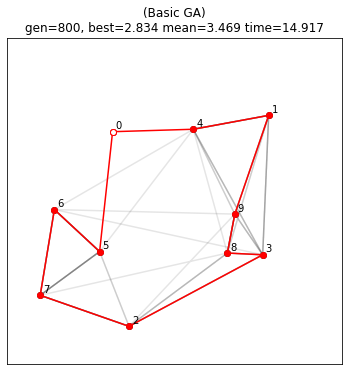

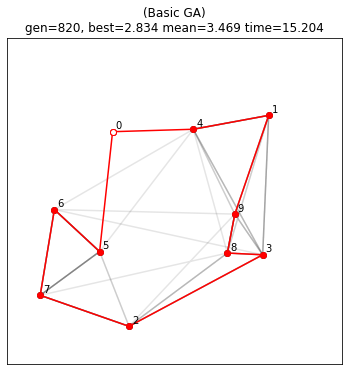

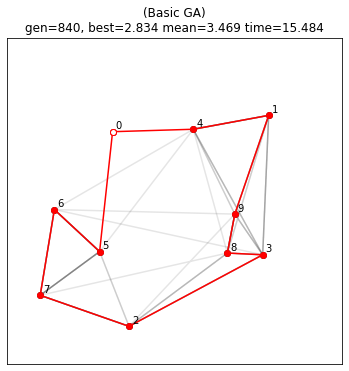

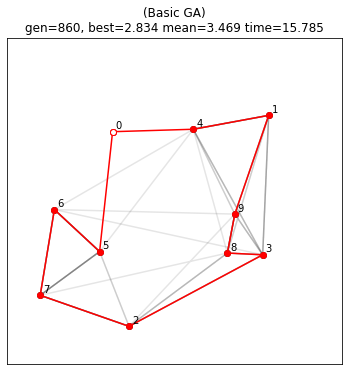

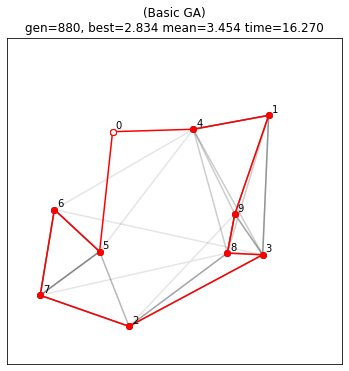

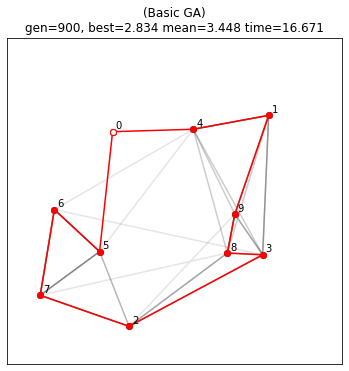

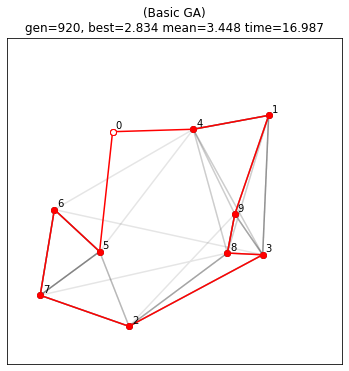

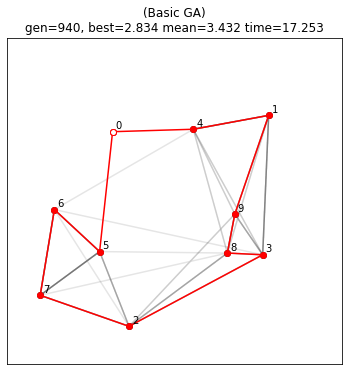

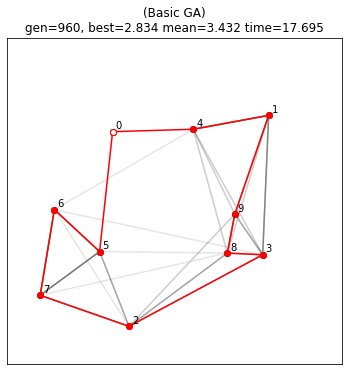

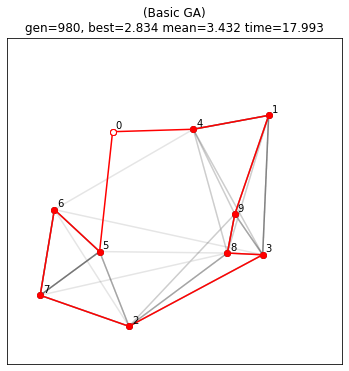

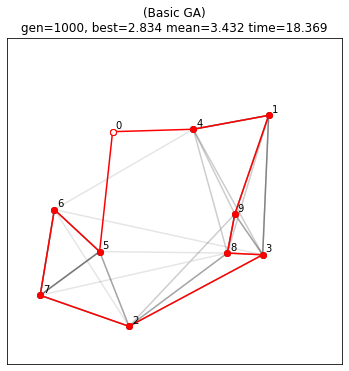

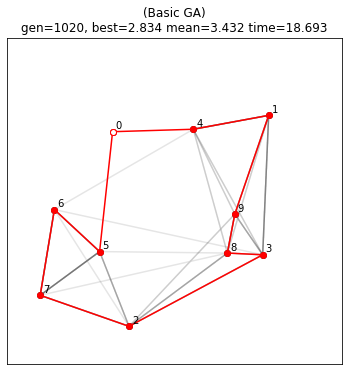

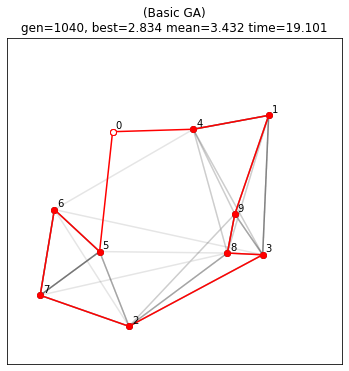

CPU times: total: 18 s
Wall time: 19.4 s


In [137]:
%%time

START_TIME = time.time()
STOPPING_CRITERIA = 100
previous_mean_score = 1
last_10 = []
counter = 0
current_best = 100000
MAX_GEN = 10000

walltime = time.time()
cputime = time.process_time()

for i in range(MAX_GEN):
    population, costs, info = evolution(population, costs, mutation_rate=0.7, gen=i, start_time=START_TIME)
    
    if i % 20 == 0:
        tsp_show_pool(population, **info)
#     print(info['mean_score'], previous_mean_score)
    relative_tolerance = abs(previous_mean_score - (info['mean_score']))/(previous_mean_score)
    
    if info['mean_score'] < current_best:
        current_best = info['mean_score']
        counter = 0

    else:
        counter += 1
    
    if counter == STOPPING_CRITERIA:
        break

        
self_walltime = time.time()-walltime
self_cputime = time.process_time()-cputime

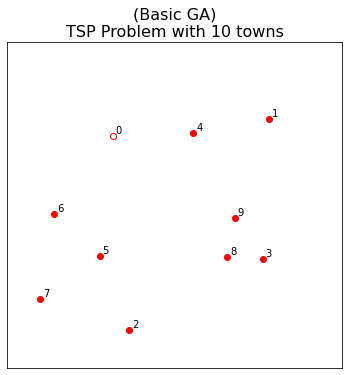

In [138]:
plt.figure(figsize=(6, 6))

for i in range(NO_TOWNS):
    if i == STARTING_TOWN:
        plt.scatter(towns_x[i], towns_y[i], c='white', edgecolors='red')
        
    else:
        plt.scatter(towns_x[i], towns_y[i], c='red')
        

    plt.text(towns_x[i]+0.01, towns_y[i]+0.01, i)

plt.title(f'(Basic GA)\nTSP Problem with {NO_TOWNS} towns', fontsize=16)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.tick_params(     
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
plt.savefig('visualisations_self/Init.png', facecolor='white', transparent=False)

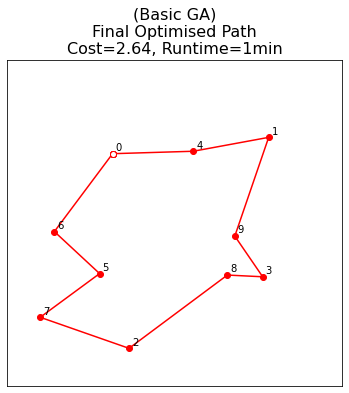

In [139]:
plt.figure(figsize=(6, 6))

best_path = np.concatenate(([STARTING_TOWN], best_path, [STARTING_TOWN]))

plt.plot(towns_x[best_path], towns_y[best_path], 'or-')
plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X

for i, xy in enumerate(zip(towns_x, towns_y), 0):
    plt.text(xy[0]+0.01, xy[1]+0.01, s=i)

plt.title(f'(Basic GA)\nFinal Optimised Path\nCost={score:.3}, Runtime=1min', fontsize=16)
plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
plt.tick_params(     
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    
plt.savefig('visualisations_self/Optimised Path.png', facecolor='white', transparent=False)

In [141]:
png_dir = 'training_images_self'
images = []
    
for i in range(15):
    images.append(imageio.v2.imread('visualisations_self/Init.png'))
    
for file_name in sorted([int(i.replace('.png','')) for i in os.listdir(png_dir)]):
    file_path = os.path.join(png_dir, str(file_name) + '.png')
    images.append(imageio.v2.imread(file_path))
    
for i in range(15):
    images.append(imageio.v2.imread('visualisations_self/Optimised Path.png'))
    
imageio.mimsave('training_gif_self.gif', images, duration=0.1)